In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

dataset description: This dataset contains transactions for a UK-based online retail store (about 500K rows). Each row = one product purchase.

link: https://www.kaggle.com/datasets/abhishekrp1517/online-retail-transactions-dataset

In [26]:

df = pd.read_csv('OnlineRetail.csv')
print(df.shape)
print(df.head())

(541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55       17850  United Kingdom  
1  2010-12-01 08:26:00       3.39       17850  United Kingdom  
2  2010-12-01 08:26:00       2.75       17850  United Kingdom  
3  2010-12-01 08:26:00       3.39       17850  United Kingdom  
4  2010-12-01 08:26:00       3.39       17850  United Kingdom  


In [27]:
print(df.info())
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  int64  
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 33.1+ MB
None
InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64


In [28]:
df = df.dropna(subset=['CustomerID'])


In [29]:
print("Unique customers:", df['CustomerID'].nunique())
print("Unique products:", df['StockCode'].nunique())

Unique customers: 4372
Unique products: 4070


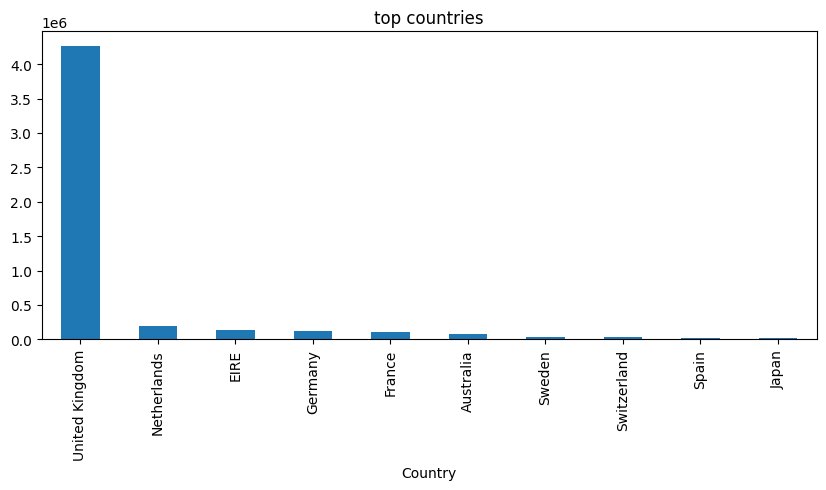

In [30]:


# sales per country
country_sales = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(10)
country_sales.plot(kind='bar', figsize=(10,4))
plt.title('top countries')
plt.show()

Most transactions are from the UK, so we’ll focus on UK customers for consistent segmentation.

In [31]:

df_uk = df[df['Country'] == 'United Kingdom'].copy()


df_uk['TotalPrice'] = df_uk['Quantity'] * df_uk['UnitPrice']


df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])


snapshot_date = df_uk['InvoiceDate'].max() + pd.Timedelta(days=1)

# recency
# frequency
# monetary
rfm = df_uk.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  
    'InvoiceNo': 'nunique',                                  
    'TotalPrice': 'sum'                                       
}).reset_index()


rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']



rfm = rfm.replace([np.inf, -np.inf], np.nan)  
#drop null value
rfm = rfm.dropna(subset=['Recency', 'Frequency', 'Monetary'])  

# remove zero
rfm = rfm[(rfm['Recency'] > 0) & (rfm['Frequency'] > 0) & (rfm['Monetary'] > 0)]

# log transform to avoid skewness
rfm['Monetary'] = np.log1p(rfm['Monetary'])
rfm['Recency'] = np.log1p(rfm['Recency'])
rfm['Frequency'] = np.log1p(rfm['Frequency'])

rfm.head()

,CustomerID,Recency,Frequency,Monetary
1,12747,1.098612,2.484907,8.342128
2,12748,0.693147,5.416100,10.277569
3,12749,1.609438,2.197225,8.260803
4,12820,1.386294,1.609438,6.849427
5,12821,5.370638,0.693147,4.540312


calculate the recency(most recent date), frequency and monetary(total money spend)

In [32]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3904 entries, 1 to 3949
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3904 non-null   int64  
 1   Recency     3904 non-null   float64
 2   Frequency   3904 non-null   float64
 3   Monetary    3904 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 152.5 KB


In [33]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

Modeling Clustering
+K-Means
+Agglomerative Clustering

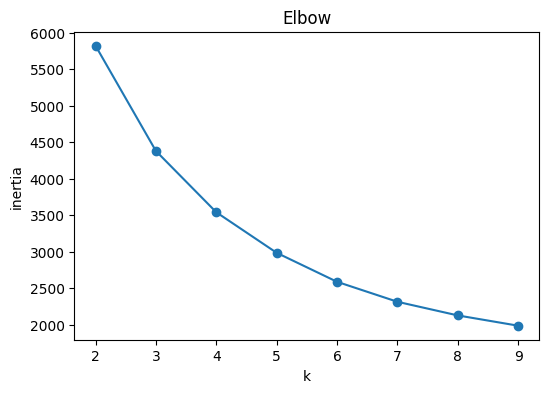

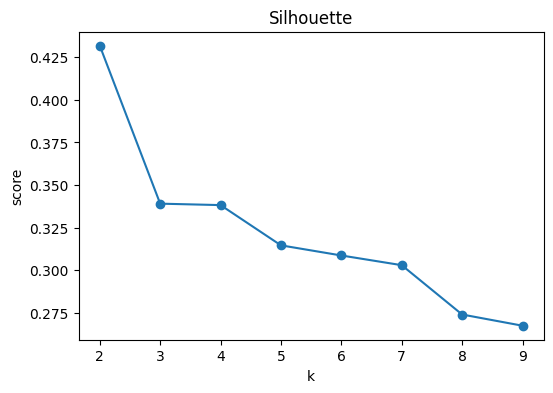

In [34]:
inertia = []
sil = []
K = range(2,10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(K, sil, marker='o')
plt.title('Silhouette')
plt.xlabel('k')
plt.ylabel('score')
plt.show()

In [35]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(X)
print(rfm.groupby('Cluster_KMeans').mean())


                  CustomerID   Recency  Frequency  Monetary
Cluster_KMeans                                             
0               15585.652448  5.006107   0.864491  5.514518
1               15500.989247  2.071132   2.649761  8.273600
2               15620.001277  2.679938   1.155823  6.075693
3               15520.463462  4.006055   1.722060  7.160180
